In [94]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from numpy import *
import glob
import scipy 
from datetime import datetime as dt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
sns.style = 'darkgrid'
plt.rcParams["figure.figsize"] = (10,5)

In [95]:
scaler = MinMaxScaler()

In [96]:
def combine_emas(ema_name): 
    """
    input: ema_name -- name of the ema we're looking at
    output: dataframe containing the data from the desired ema compiled for all uids
    """
    # list of all the desired ema's 
    all_emas = glob.glob('dataset/dataset/EMA/response/' + ema_name + '/' + ema_name +'_*.json')
    # index to start the uid
    uid_start = len('dataset/dataset/EMA/response/' + ema_name + '/' + ema_name +'_')
    # this is where we'll compile the data
    total_ema_data = pd.DataFrame()
    # loops through all the ema data
    for ema in all_emas: 
        # the uid is the three characters starting at uid_start index
        uid = ema[uid_start:uid_start + 3]
        # read the data
        ema_data = pd.read_json(ema)
        # keep track of uids
        ema_data['uid'] = uid
        # compile the data
        total_ema_data = total_ema_data.append(ema_data)
    
    total_ema_data['day of week'] = total_ema_data['resp_time'].dt.dayofweek
    total_ema_data['day'] = total_ema_data['resp_time'].dt.dayofyear
    return total_ema_data    

In [97]:
def merge_EMA(EMA_list): 
    """
    input: EMA_list -- contains a list of tuples, each tuple containing the name of an EMA and the name of a desired column
    in that EMA.
    output: a dataframe combining all those EMA's for every user. 
    """
    initialized = False
    for tup in EMA_list: 
        ema = tup[0]
        col = tup[1]
        
        ema_for_all_students = combine_emas(ema)
        relevant_columns = ema_for_all_students[[col, 'day', 'day of week', 'uid']]
        
        if initialized is False: 
            initialized = True
            overall_merge = relevant_columns
        else: 
            overall_merge = overall_merge.merge(relevant_columns, on = ['day', 'day of week', 'uid'], how = 'inner')
    
    return overall_merge

In [98]:
#This dataframe has mood and PAM data for each student for each day of the semester for which there is data.
mood_and_PAM = merge_EMA([('PAM', 'picture_idx'), ('Mood', 'happy')])

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [99]:
#This dataframe has mood, PAM, Stress and Social data for each student for each day of the semester for which there is data.
ema_df = merge_EMA([('PAM', 'picture_idx'), ('Stress', 'level'), ('Mood', 'happy'), ('Social', 'number')])

#This dataframe has PAM data for each student for each day of the semester.
pam = merge_EMA([('PAM', 'picture_idx')])

In [100]:
#I wanted my model to predict the avg. positive affect scores for each student on a particular day.
#I randomly chose the 100th day of the year as the day for which I would run my model.
#The function below returns the average positive affect values for each student for that 100th day.
def get_data_day_100(data):
    data_100 = data[data['day'] == 100]
    data_100 = data_100.groupby('uid').picture_idx.mean()
    return data_100
pam_100 = get_data_day_100(pam)

#In my second model, I wanted to predict the post-PHQ-9 depression survey scores.
#I used positive affect data as one of my features, and this function returns the average positive affect values for each student throughout the semester.
def get_data_sem(data):
    data_sem = data.groupby('uid').picture_idx.mean()
    return data_sem
pam_sem = get_data_sem(pam)

In [101]:
#This function loads the conversation data for each student throughout the semester.
def convo_data():
    #The directory used to extract the convo_files might be different for your computer.
    #The directory depends on where your jupyter notebook is, and how many files in the desired data you want to extract is.
    convo_files = glob.glob("dataset/dataset/sensing/conversation/conversation_*.csv")
    uid_start = len("dataset/dataset/sensing/conversation/conversation_")

    for file in convo_files: 
    
        uid = file[uid_start:uid_start+3]
    
        if uid == 'u10': 
            conversations = pd.read_csv(file)
            conversations['uid'] = uid
       # print(conversations)
            continue
        
        conv_df = pd.read_csv(file)
        conv_df['uid'] = uid
        conversations = pd.concat([conv_df, conversations], ignore_index = True)
    return conversations
conversations = convo_data()

In [102]:
#This function further processes the conversation data and adds the following information:
    #convo length, start hour, end hour, and day of the year
def process_convos(data):
    data['convo_length'] = data[' end_timestamp'] - data['start_timestamp']

    data['start_timestamp'] = pd.to_datetime(data['start_timestamp'], unit = 's')
    data[' end_timestamp'] = pd.to_datetime(data[' end_timestamp'], unit = 's')

    data['start hour'] = data['start_timestamp'].dt.hour
    data['end hour'] = data[' end_timestamp'].dt.hour
    data['Day'] = data['start_timestamp'].dt.dayofyear
    return data
conversations = process_convos(conversations)

In [103]:
#This function returns a new column of tuples of start and end hours of each conversations
def get_epoch_tuples(data):
    data['epoch'] = list(zip(data['start hour'], data['end hour']))
    return data
conversations = get_epoch_tuples(conversations)

In [104]:
#This function labels each conversation as either occuring in the Day, Evening or Night epochs.
def epoch(times_tuple):        
        start = times_tuple[0]
        end = times_tuple[1]
        
        if (start and end) > 10 and (start and end) <=18:
            return 'Day'
        elif (start and end) >0 and (start and end) <=10:
            return 'Night'
        elif (start and end) >18:
            return 'Evening'
conversations['epoch'] = conversations['epoch'].apply(epoch)

In [105]:
#This function extracts the number of conversations each student had on the 100th day of the year.
def get_data_day_100(data):
    data_100 = data[data["Day"] == 100]
    data_100 = data_100.groupby('uid').convo_length.count()
    return data_100
convo_100 = get_data_day_100(conversations)
convo = conversations[conversations['Day']==100]

In [106]:
#This function returns the number of conversations each student had throughout the semester.
def get_data_sem(data):
    data_sem = data.groupby('uid').convo_length.count()
    return data_sem
convo_sem = get_data_sem(conversations)

In [107]:
#This function creates a dataframe of the # of conversations each student had on day 100
#I created this dataframe so that I could later merge other sensing data to this dataframe.
def convo_dataframe(data1, data2): #data=convo    
    unique_ids = []
    for i in data1['uid']:
        if i not in unique_ids:
            unique_ids.append(i)
    unique_ids
    convo_ids = sorted(unique_ids)
    df = pd.DataFrame({'uid': list(convo_ids), 'convos': list(data2)})
    return df
df = convo_dataframe(convo, convo_100)

In [108]:
#This function loads the sleep data for each student.
def sleep_data():
    sleep_files = glob.glob("dataset/dataset/education/Sleep_*.json")
    uid_start = len("dataset/dataset/education/Sleep_")

    for file in sleep_files: 
    
        uid = file[uid_start:uid_start+3]
    
        if uid == 'u01': 
            sleep = pd.read_json(file)
            sleep['uid'] = uid
       # print(conversations)
            continue
        
        sleep_df = pd.read_json(file)
        sleep_df['uid'] = uid
        sleep = pd.concat([sleep_df, sleep], ignore_index = True)
    return sleep
sleep = sleep_data()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [109]:
#This function processes the sleep data. 
#It returns new sleep data (the hours of sleep for each student on day 100)
#It also returns an updated sleep dataframe with a new column: Day (day of the year)
def process_sleep(data):
    data['Day'] = data['resp_time'].dt.dayofyear
    data_100 = data[data['Day'] == 100]
    data_100['Hour'] = data_100['hour']
    data_100 = (data_100.groupby('uid').Hour.mean())
    return data_100, data
sleep_100, sleep = process_sleep(sleep)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [110]:
#This function returns the average amount of sleep each student received throughout the semester.
def get_data_sem(data):
    data_sem = data.groupby('uid').hour.count()
    return data_sem
sleep_sem = get_data_sem(sleep)
#sleep_sem = (sleep.groupby('uid').hour.mean())

In [111]:
#This function returns the bluetooth data for each student.
def bluetooth_data():    
    bt_files = glob.glob("dataset/dataset/sensing/bluetooth/bt_*.csv")
#files = glob.glob("dataset/survey/conversation/conversation_*.csv")
    uid_start = len("dataset/dataset/sensing/bluetooth/bt_")
#uid_start = len("conversation_*")

    for file in bt_files: 
    
        uid = file[uid_start:uid_start+3]
    
        if uid == 'u45': 
            bluetooth = pd.read_csv(file)
            bluetooth['uid'] = uid
       # print(conversations)
            continue

        bt_df = pd.read_csv(file)
        bt_df['uid'] = uid
        bluetooth = pd.concat([bt_df, bluetooth], ignore_index = True)
    return bluetooth
bluetooth = bluetooth_data()

In [112]:
#This function processes the bluetooth data. 
#It returns new bluetooth data (bt_100): the number of bluetooth co-locations for each student on day 100
#It also returns an updated bluetooth dataframe with a new column: Day (day of the year)
def process_bluetooth(data):
    data['time'] = pd.to_datetime(data.time, unit='s')
    data['Day'] = data.time.dt.dayofyear
    data_100 = data[data['Day'] == 100]
    #data_100['Hour'] = data_100['hour']
    data_100 = (data_100.groupby('uid').Day.count())
    return data_100, data
bt_100, bluetooth = process_bluetooth(bluetooth)

In [113]:
#This funtion returns the number of bluetooth co-locations each student had throuhgout the semester.
def get_data_sem(data):
    data_sem = data.groupby('uid').Day.count()
    return data_sem
bt_sem = get_data_sem(bluetooth)

In [114]:
#This dataframe merges all of the important data for the positive affect model
def PAM_df(df, data1, data2, data3):
    df = df.merge(data1, on='uid', how='inner')
    df = df.merge(data2, on='uid', how='inner')
    df = df.merge(data3, on='uid', how='inner')
    df.rename(columns={'Day':'Num Bt Coloc'}, inplace=True)
    return df
df = PAM_df(df, bt_100, sleep_100, pam_100)

In [115]:
df.head()

,uid,convos,Num Bt Coloc,Hour,picture_idx
0,u00,34,51,5.0,11.000000
1,u02,20,121,8.0,7.800000
2,u03,15,113,7.0,10.333333
3,u04,47,97,6.0,4.666667
4,u07,37,173,8.0,14.000000


In [116]:
from sklearn import cluster
from sklearn.cluster import KMeans

In [117]:
#This reads the PHQ-9 data.
PHQ_9 = pd.read_csv('dataset/dataset/survey/PHQ-9.csv')

#This function creates two new dataframes for each type of PHQ-9 survey: pre and post.
def phq9_type(data):
    data1_pre = data[data['type'] == 'pre']
    #PHQ_9_pre = PHQ_9[PHQ_9['type'] == 'pre']
    data1_post = data[data['type'] == 'post']
    return data1_pre, data1_post
PHQ_9_pre, PHQ_9_post = phq9_type(PHQ_9)

In [118]:
#This function adds a new column to the pre-PHQ-9 data: the scores of the survey.
def pre_score(response):
    if response == 'Not at all':
        return 0
    elif response == 'More than half the days':
        return 2
    elif response == 'Several days':
        return 1
    elif response == 'Nearly every day':
        return 3
    else:
        return response
phq9_pre = PHQ_9_pre.applymap(pre_score)

#This function creates a new column for the PHQ-9 pre scores.
phq9_pre['Score'] = phq9_pre.sum(axis=1, skipna = True)
#phq9_pre.head()

In [119]:
#ema_final = pd.merge(phq9_pre, convo, on='uid', how='inner')
#ema_final.head()

In [120]:
#This function adds a new column to the post-PHQ-9 data: the scores of the survey.
def post_score(response):
    if response == 'Not at all':
        return 0
    elif response == 'More than half the days':
        return 2
    elif response == 'Several days':
        return 1
    elif response == 'Nearly every day':
        return 3
    else:
        return response
phq9_post = PHQ_9_post.applymap(post_score)

#This function creates a new column for the PHQ-9 post scores.
phq9_post['Score'] = phq9_post.sum(axis=1, skipna = True)
phq9_post = phq9_post.reset_index()
#phq9_post_id = pd.DataFrame({'uid': phq9_post['uid'], 'Score': phq9_post['Score']})

In [121]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

In [122]:
#This function returns the correlations between each of the data in the dataframe df
#It shows correlations between num convos, num bluetooth colocations, positive effect, and hours of sleep.
def get_corr(data):
    df_correlations = data.corr()
    return df_correlations
df_correlations = get_corr(df)

In [123]:
df_correlations

,convos,Num Bt Coloc,Hour,picture_idx
convos,1.000000,0.187659,-0.215013,0.015917
Num Bt Coloc,0.187659,1.000000,0.179156,0.234946
Hour,-0.215013,0.179156,1.000000,0.023037
picture_idx,0.015917,0.234946,0.023037,1.000000


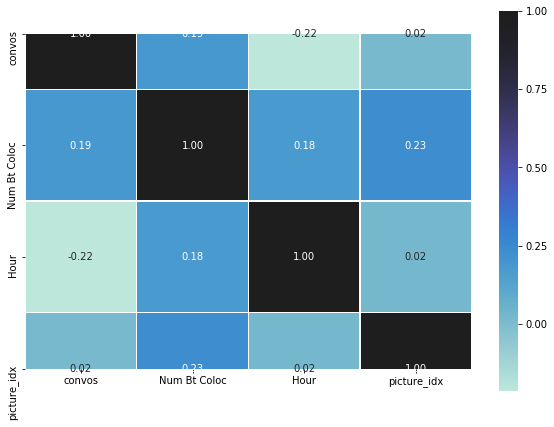

In [124]:
#This function creates a heatmap of the correlations from the previous dataframe
def correlation_heatmap(data):
    correlations = data.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=1, fmt='.2f',
                square=True, linewidths=0.5, annot=True, cbar_kws={"shrink": .7})
    plt.show()
    
    
correlation_heatmap(df)

In [125]:
#This function returns the features and scaled features for the positive affect model
def features(data):
    feat = data[['convos', 'Num Bt Coloc', 'Hour']].values
    scaler=Normalizer()
    scaler.fit(feat)
    X_scaled_pam = scaler.transform(feat)
    return feat, X_scaled_pam
feat_pam, X_scaled_pam = features(df)

In [126]:
#This function runs the PCA algorithm on our features data.
def pca_pam_model(scaled_feat, data):
    pca = PCA(n_components=3)
    pca.fit(scaled_feat)
    X_pca_pam = pca.transform(scaled_feat)
    targ_pam = data['picture_idx'].values
    return X_pca_pam, targ_pam
X_pca_pam, targ_pam = pca_pam_model(X_scaled_pam, df)

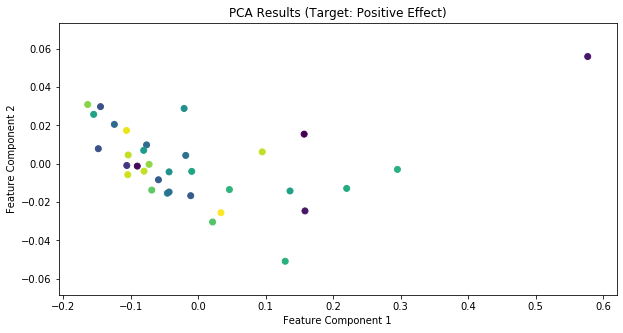

In [127]:
#This function plots the PCA models of our feature data.
#We do this to visualize our data and identify clusters, but we couldn't identify any meaningful clusters.
def pca_pam_plot(pca_feat, target):
    plt.scatter(x=pca_feat[:,0], y=pca_feat[:,1], c = target)
    plt.xlabel('Feature Component 1')
    plt.ylabel('Feature Component 2')
    plt.title('PCA Results (Target: Positive Effect)')
    return plt.show()
pca_pam_plot(X_pca_pam, targ_pam)

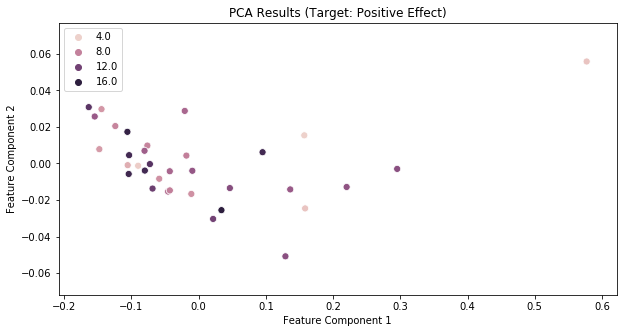

In [128]:
#This is a seaborn plot of the same plot of the PCA above.
def pca_pam_plot_sns(pca_feat, target):
    sns.scatterplot(x=pca_feat[:,0], y=pca_feat[:,1], hue = target, s=50)
    plt.xlabel('Feature Component 1')
    plt.ylabel('Feature Component 2')
    plt.title('PCA Results (Target: Positive Effect)')
    return plt.show()
pca_pam_plot_sns(X_pca_pam, targ_pam)

In [129]:
from sklearn import cluster
from sklearn.cluster import KMeans

#This runs the kmeans cluster algorithm on our positive affect features data.
kmeans = KMeans(n_clusters=2, random_state=0).fit(feat_pam)
ykmeans = kmeans.predict(feat_pam)

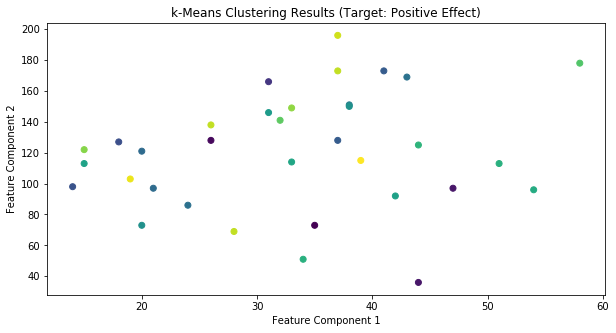

In [130]:
#This visualizes the kmeans clustering model on our positive affect features data.
#We do this to identify any clusters, but couldn't identify any meaningful clusters
def kmeans_plot(feat, target):
    plt.scatter(x=feat[:,0], y=feat[:,1], c = targ_pam)
    plt.xlabel('Feature Component 1')
    plt.ylabel('Feature Component 2')
    plt.title('k-Means Clustering Results (Target: Positive Effect)')
    return plt.show()
kmeans_plot(feat_pam, targ_pam)

In [131]:
from sklearn.model_selection import train_test_split

#This function splits our positive affect features and target data into test and training sets.
def train_test(features, target):
    x_train, x_test, y_train, y_test = train_test_split(features, target, random_state=0)
    return x_train, x_test, y_train, y_test
x_train, x_test, y_train, y_test = train_test(feat_pam, targ_pam)

In [132]:
#We used 3 linear models: Linear regressoion, Lasso, and Ridge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

In [133]:
linreg = LinearRegression()
lasso = Lasso(alpha=0.001, random_state=0)
ridge = Ridge(alpha=0.001, random_state=0)

In [134]:
#This function scales our features data.
scaler = StandardScaler()
def scaling_data(x_train, x_test):
    scaler.fit(x_train)
#scaler.fit(y_train.reshape(-1,1))
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)
    return x_train, x_test
x_train, x_test = scaling_data(x_train, x_test)
#y_train = scaler.transform(y_train.reshape(-1,1))
#y_test = scaler.transform(y_test.reshape(-1,1))

In [135]:
#This function returns the performance of our models.
def model_performance (x_train, x_test, y_train, y_test):
    linreg.fit(x_train, y_train)
    lasso.fit(x_train, y_train)
    ridge.fit(x_train, y_train)
    linreg_train = ('Training set score LinReg {:2f}'.format(linreg.score(x_train, y_train)))
    lasso_train = ('Training set score Lasso {:2f}'.format(lasso.score(x_train, y_train)))
    ridge_train = ('Training set score Ridge {:2f}'.format(ridge.score(x_train, y_train)))
    linreg_test = ('Test set score LinReg {:2f}'.format(linreg.score(x_test, y_test)))
    lasso_test = ('Test set score Lasso {:2f}'.format(lasso.score(x_test, y_test)))
    ridge_test = ('Test set score Ridge {:2f}'.format(ridge.score(x_test, y_test)))
    return linreg_train, lasso_train, ridge_train, linreg_test, lasso_test, ridge_test
model_performance(x_train, x_test, y_train, y_test)

('Training set score LinReg 0.096005',
 'Training set score Lasso 0.096004',
 'Training set score Ridge 0.096005',
 'Test set score LinReg -0.393244',
 'Test set score Lasso -0.391304',
 'Test set score Ridge -0.393199')

In [136]:
#As you can see, there is still much room for improvement for our positive affect models.
#To improve our model, we hope to add more features data.

In [137]:
phq9_post.head()

,index,uid,type,Little interest or pleasure in doing things,"Feeling down, depressed, hopeless.","Trouble falling or staying asleep, or sleeping too much.",Feeling tired or having little energy,Poor appetite or overeating,Feeling bad about yourself or that you are a failure or have let yourself or your family down,"Trouble concentrating on things, such as reading the newspaper or watching television",Moving or speaking so slowly that other people could have noticed. Or the opposite being so figety or restless that you have been moving around a lot more than usual,"Thoughts that you would be better off dead, or of hurting yourself",Response,Score
0,46,u00,post,0,0,0,1,0,1,1,0,0,Somewhat difficult,3
1,47,u01,post,0,1,1,1,0,0,0,1,0,Somewhat difficult,4
2,48,u02,post,2,0,0,1,1,0,1,0,0,Somewhat difficult,5
3,49,u03,post,1,1,0,1,0,1,0,0,0,Somewhat difficult,4
4,50,u04,post,1,1,1,1,1,2,1,0,0,Somewhat difficult,8


In [138]:
#This function merges sensing data with phq9_post data.
def add_sensing_phq9(data, sleep, convo, pam, bt):
    data = data.merge(sleep, on='uid', how='inner')
    data = data.merge(convo, on='uid', how='inner')
    data = data.merge(pam, on='uid', how='inner')
    data = data.merge(bt, on='uid', how='inner')
    data.rename(columns={'convo_length':'Num Convos', 'picture_idx': 'Positive Effect'}, inplace=True)
    return data

phq9_post = add_sensing_phq9(phq9_post, sleep_sem, convo_sem, pam_sem, bt_sem)

In [139]:
phq9_post

,index,uid,type,Little interest or pleasure in doing things,"Feeling down, depressed, hopeless.","Trouble falling or staying asleep, or sleeping too much.",Feeling tired or having little energy,Poor appetite or overeating,Feeling bad about yourself or that you are a failure or have let yourself or your family down,"Trouble concentrating on things, such as reading the newspaper or watching television",Moving or speaking so slowly that other people could have noticed. Or the opposite being so figety or restless that you have been moving around a lot more than usual,"Thoughts that you would be better off dead, or of hurting yourself",Response,Score,hour,Num Convos,Positive Effect,Day
0,46,u00,post,0,0,0,1,0,1,1,0,0,Somewhat difficult,3,55,2111,8.605128,7322
1,47,u01,post,0,1,1,1,0,0,0,1,0,Somewhat difficult,4,27,2179,9.971429,6544
2,48,u02,post,2,0,0,1,1,0,1,0,0,Somewhat difficult,5,26,1483,9.000000,18784
3,49,u03,post,1,1,0,1,0,1,0,0,0,Somewhat difficult,4,28,478,8.000000,2806
4,50,u04,post,1,1,1,1,1,2,1,0,0,Somewhat difficult,8,34,2737,8.651376,7374
5,51,u05,post,0,0,0,0,0,0,0,0,0,Not difficult at all,0,6,1640,9.333333,59416
6,52,u07,post,1,1,2,2,2,0,0,0,0,Somewhat difficult,8,24,1373,9.993197,9161
7,53,u09,post,0,0,0,0,1,1,0,0,0,Not difficult at all,2,3,2269,10.000000,13842
8,55,u14,post,0,0,1,1,1,0,0,0,0,NaN,3,30,1879,8.176768,40601
9,56,u15,post,0,0,1,0,0,0,0,0,0,Not difficult at all,1,19,1052,9.075472,5413


In [140]:
#This function further processes our data to create a dataframe of only the features and target data.
def processed_phq9_df(data):
    phq9_post_df = pd.DataFrame({'uid': data['uid'], 'Score': data['Score'], 'Sleep Dur': data['hour'], 'Num Convos': data['Num Convos'], 'Positive Effect': data['Positive Effect'], 'Num Bt Coloc': data['Day']})
    return phq9_post_df
phq9_post_df = processed_phq9_df(phq9_post)

In [141]:
#This function looks at the correlations between the following data:
    #Sleep duration, post phq9 scores, # of convos, Positive affect, and # of Bluetooth colocations
def correlations(data):
    data_corr = data.corr()
    return data_corr
phq9_post_df_correlations = correlations(phq9_post_df)
phq9_post_df_correlations

,Score,Sleep Dur,Num Convos,Positive Effect,Num Bt Coloc
Score,1.000000,0.197845,-0.201394,-0.036387,-0.303408
Sleep Dur,0.197845,1.000000,0.351703,0.180291,0.017177
Num Convos,-0.201394,0.351703,1.000000,0.264090,0.160903
Positive Effect,-0.036387,0.180291,0.264090,1.000000,0.087117
Num Bt Coloc,-0.303408,0.017177,0.160903,0.087117,1.000000


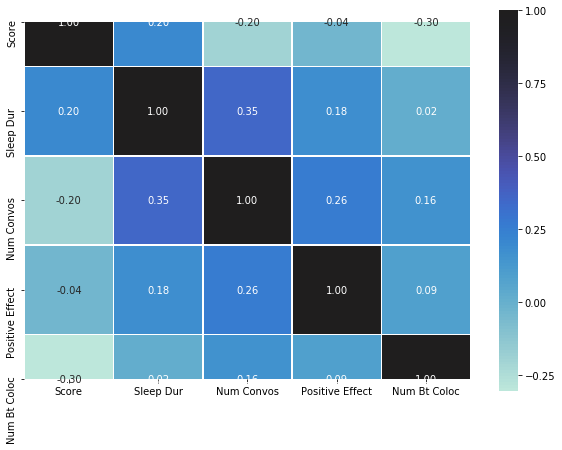

In [142]:
#This function returns a heatmap of the correlations
def correlation_heatmap(data):
    correlations = data.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=1, fmt='.2f',
                square=True, linewidths=0.5, annot=True, cbar_kws={"shrink": .7})
    plt.show()
    
    
correlation_heatmap(phq9_post_df)

In [143]:
#This function splits the dataframe into features and target data
#This function also scales the feature data for PCA analysis
def features(data):
    feat = data[['Sleep Dur', 'Num Bt Coloc', 'Num Convos', 'Num Bt Coloc']].values
    targ_phq_9 = data['Score'].values
    scaler=StandardScaler()
    scaler.fit(feat)
    X_scaled_phq9 = scaler.transform(feat)
    return feat, X_scaled_phq9, targ_phq_9
feat_phq9, X_scaled_phq9, targ_phq_9 = features(phq9_post_df)

In [144]:
#This function runs the PCA model on our scaled features data.
def pca_phq9_model(scaled_feat):
    pca = PCA(n_components=2)
    pca.fit(X_scaled_phq9)
    X_pca_phq9 = pca.transform(X_scaled_phq9)
    return X_pca_phq9
X_pca_phq9 = pca_phq9_model(X_scaled_phq9)

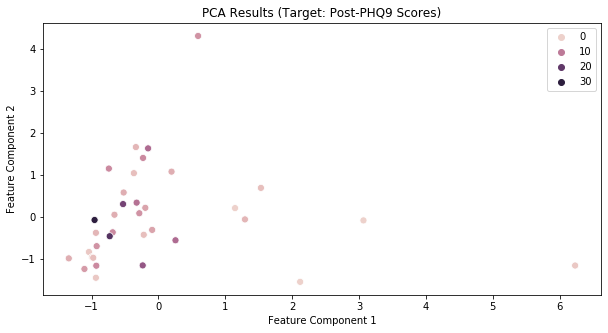

In [145]:
#This function plots the result of the PCA model.
#We could not identify any meaningful clusters.
def pca_phq9_plot_sns(pca_feat, target):
    sns.scatterplot(x=pca_feat[:,0], y=pca_feat[:,1], hue = target, s=50)
    plt.xlabel('Feature Component 1')
    plt.ylabel('Feature Component 2')
    plt.title('PCA Results (Target: Post-PHQ9 Scores)')
    return plt.show()
pca_phq9_plot_sns(X_pca_phq9, targ_phq_9)

In [146]:
from sklearn.model_selection import train_test_split

#This function splits the features and target data into testing and training sets.
def train_test(feat, target):
    x_train, x_test, y_train, y_test = train_test_split(feat, target, random_state=0)
    return x_train, x_test, y_train, y_test
x_train, x_test, y_train, y_test = train_test(feat_phq9, targ_phq_9)

In [147]:
linreg = LinearRegression()
lasso = Lasso(alpha=0.01, random_state=0)
ridge = Ridge(alpha=0.01, random_state=0)

In [148]:
scaler = Normalizer()

#This function returns the scaled features data.
def scaling_data(x_train, x_test):
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)
    return x_train, x_test
x_train, x_test = scaling_data(x_train, x_test)

In [149]:
#We used three linear models: linear regression, lasso and ridge
#This function returns the training and test set scores for each model
def model_performance (x_train, x_test, y_train, y_test):
    linreg.fit(x_train, y_train)
    lasso.fit(x_train, y_train)
    ridge.fit(x_train, y_train)
    linreg_train = ('Training set score LinReg {:2f}'.format(linreg.score(x_train, y_train)))
    lasso_train = ('Training set score Lasso {:2f}'.format(lasso.score(x_train, y_train)))
    ridge_train = ('Training set score Ridge {:2f}'.format(ridge.score(x_train, y_train)))
    linreg_test = ('Test set score LinReg {:2f}'.format(linreg.score(x_test, y_test)))
    lasso_test = ('Test set score Lasso {:2f}'.format(lasso.score(x_test, y_test)))
    ridge_test = ('Test set score Ridge {:2f}'.format(ridge.score(x_test, y_test)))
    return linreg_train, lasso_train, ridge_train, linreg_test, lasso_test, ridge_test
model_performance(x_train, x_test, y_train, y_test)

('Training set score LinReg 0.083109',
 'Training set score Lasso 0.000000',
 'Training set score Ridge 0.001741',
 'Test set score LinReg -0.031089',
 'Test set score Lasso -0.110580',
 'Test set score Ridge -0.107792')

In [150]:
#There is still room for improvement with this model, and we hope to improve it by adding more features data.